In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path

In [2]:
DATA_DIR = Path('data')
SUDOKUS = DATA_DIR / 'sudokus'

train_ids = set(f.name.rstrip('.jpg') for f in (SUDOKUS / 'v2_train').glob('*.jpg'))

locs = pd.read_csv(SUDOKUS / 'outlines_sorted.csv', sep=',')
locs['image_id'] = locs['filepath'].str.split('/').str[-1].str.rstrip('.jpg')
locs = locs[locs['image_id'].isin(train_ids)]
locs = locs.set_index('image_id', drop=True)
locs = locs.drop(columns=['filepath'])
locs.head()

,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
image_id,,,,,,,,
image1082,101,270,885,272,872,1060,105,1053
image125,13,11,409,0,423,415,10,427
image188,14,10,534,9,538,447,20,457
image155,92,10,543,15,543,465,84,470
image200,96,12,537,6,556,467,101,472


In [3]:
locs.describe()

,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,73.540881,68.547170,595.377358,68.314465,603.025157,568.188679,71.201258,574.371069
std,44.170232,99.354161,155.297619,96.153170,159.224185,234.054310,43.577630,233.392388
min,8.000000,0.000000,396.000000,0.000000,391.000000,387.000000,1.000000,403.000000
25%,34.000000,10.500000,507.500000,13.000000,509.000000,444.000000,31.000000,449.000000
50%,78.000000,22.000000,545.000000,25.000000,547.000000,455.000000,75.000000,462.000000
75%,100.500000,71.000000,595.500000,65.000000,608.500000,468.000000,97.000000,478.000000
max,245.000000,383.000000,1202.000000,383.000000,1213.000000,1246.000000,248.000000,1240.000000


In [85]:
from matplotlib.patches import Rectangle
from PIL import ImageOps


def get_image(image_id):
    img_path = SUDOKUS / 'v2_train' / f'{image_id}.jpg'
    img = Image.open(img_path)
    ImageOps.exif_transpose(img, in_place=True)
    return img

def get_bbox(image_id):
    corners = np.array(locs.loc[image_id]).reshape((4, 2))
    return corners

def plot_img(img, bbox: np.ndarray):
    if np.all(bbox < 1.0): bbox = np.floor(bbox * 224)
    points = np.concatenate((bbox, bbox[0]), axis=None).reshape((-1, 2))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.plot(points[:, 0], points[:, 1], color='r', linewidth=2)

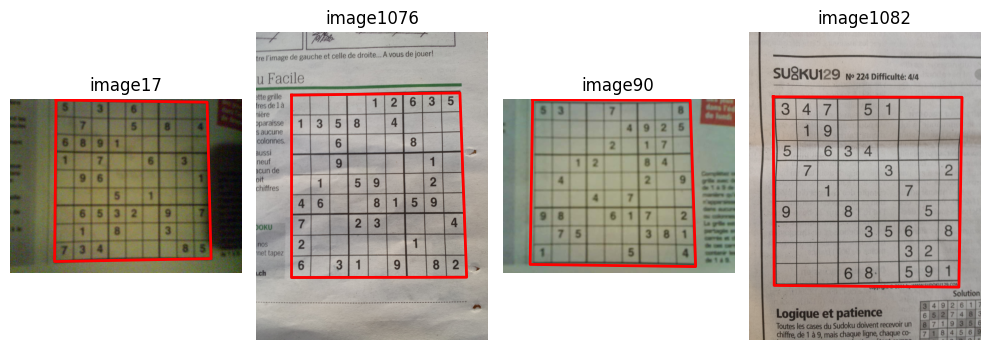

In [89]:
ixs = np.random.choice(len(locs), size=3, replace=False).tolist() + [0]

plt.figure(figsize=(10, 6))
for i, image_id in enumerate(locs.iloc[ixs].index):
    plt.subplot(1, 4, i+1)
    plt.title(image_id)
    img = get_image(image_id)
    corners = get_bbox(image_id)
    plot_img(img, corners)
plt.tight_layout();

In [74]:
def preprocess(img: Image.Image, bbox=None):
    scalex, scaley = 224 / img.width, 224 / img.height
    img = img.convert('L')
    img = img.resize((224, 224))
    img = np.array(img) / 255
    if bbox is not None:
        bbox = bbox.reshape((-1, 2)) * [scalex, scaley] / 224
    return img, bbox

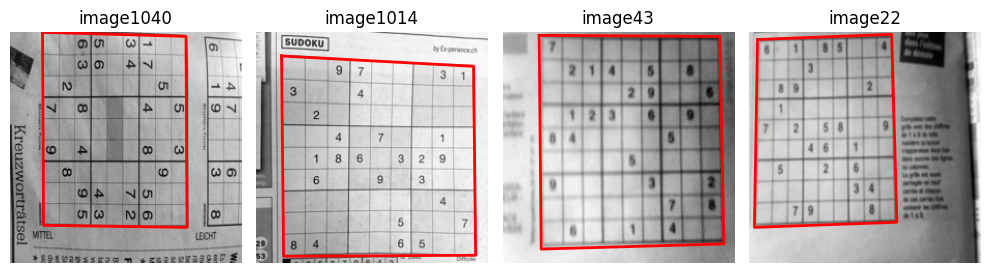

In [75]:
plt.figure(figsize=(10, 6))
for i, image_id in enumerate(locs.iloc[ixs].index):
    plt.subplot(1, 4, i+1)
    plt.title(image_id)
    img = get_image(image_id)
    corners = get_bbox(image_id)
    plot_img(*preprocess(img, corners))
plt.tight_layout();

In [78]:
images, bboxes = [], []
for image_id in locs.index:
    img, corners = preprocess(get_image(image_id), get_bbox(image_id))
    images.append(img)
    bboxes.append(corners.reshape(4*2))

images = np.stack(images)
print(f'Image values:\n\tmean: {images.mean()}\n\tstd: {images.std()}')

bboxes = pd.DataFrame(
    bboxes, 
    columns=[f'{"x" if i % 2 == 0 else "y"}{i//2}'for i in range(4*2)]
)
bboxes.head()

Image values:
	mean: 0.5367787160068429
	std: 0.12944043373444886


,x0,y0,x1,y1,x2,y2,x3,y3
0,0.105208,0.210938,0.921875,0.21250,0.908333,0.828125,0.109375,0.822656
1,0.020313,0.022917,0.639062,0.00000,0.660937,0.864583,0.015625,0.889583
2,0.021875,0.020833,0.834375,0.01875,0.840625,0.931250,0.031250,0.952083
3,0.143750,0.020833,0.848437,0.03125,0.848437,0.968750,0.131250,0.979167
4,0.150000,0.025000,0.839062,0.01250,0.868750,0.972917,0.157812,0.983333


In [79]:
corners.describe()

,x0,y0,x1,y1,x2,y2,x3,y3
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,0.101908,0.078683,0.822961,0.080010,0.833103,0.905845,0.098638,0.917197
std,0.059427,0.078351,0.082661,0.075415,0.085776,0.071422,0.057879,0.073559
min,0.012500,0.000000,0.618750,0.000000,0.610938,0.648900,0.001042,0.650516
25%,0.051302,0.021875,0.774219,0.025000,0.777344,0.891667,0.046875,0.893750
50%,0.102083,0.045833,0.837500,0.047917,0.848437,0.931250,0.093750,0.945833
75%,0.143750,0.107292,0.882812,0.110417,0.903125,0.952083,0.140625,0.964583
max,0.318750,0.299219,0.967708,0.299219,0.989583,0.995833,0.323437,0.997917


In [102]:
import torch
corners = torch.tensor(bboxes.iloc[0].values)
corners = corners.reshape((-1, 4, 2))
min_xy = corners.min(axis=1)
# max_xy = corners.max(axis=1)
# bbox = torch.cat((min_xy, max_xy), dim=1)
# corners, min_xy, max_xy, bbox
min_xy

torch.return_types.min(
values=tensor([[0.1052, 0.2109]], dtype=torch.float64),
indices=tensor([[0, 0]]))